In [334]:
import warnings
warnings.filterwarnings('ignore')

In [282]:
import pandas as pd
import numpy as np
import random
import math

from scipy.stats import mannwhitneyu, normaltest, ttest_rel, wilcoxon
import matplotlib.pyplot as plt

In [283]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Analyze data with new labels
- covers P2/P3 of homepage, rank 1-10 on the homepage
- uses automatic labels from channel lists and manual labels combined from all previous labeling iterations with consistent codebook
- perform wilc test, and watched/inferred test

## Get data with on/off-topic labels

In [284]:
topics = ['alt-right', 'antitheist', 'politics-left', 'politics-right']
strategies = ['none','watch','delete','dislike','not-interested','no-channel','dislike-recommendation']


In [285]:
# Here should include our on-topic labels
# We should also have exp_stage filled out
# Can subset to the stages for which we're calcluating on/off-topic metrics (~8330)

df = pd.read_csv('./p_levels_manual_labeled.csv')
df.head()

,Unnamed: 0,video_id,channel_id,rank,component,watch_video_id,bot_name,phase,homepage_level,videopage_level,phase_level,topic,strategy,note,exp_stage,on_topic
0,60,ohjsypZfFVg,UCkY8CvV8WQFe87CZGmvuYHA,0,homepage,NaN,alt-right_delete_0,stain,1,2,1,alt-right,delete,0,1,True
1,61,3zlvqFcinr8,UCXHcH4CggCrvIpm0KM0kHQg,1,homepage,NaN,alt-right_delete_0,stain,1,2,1,alt-right,delete,0,1,False
2,62,9Xd8xq06FCw,UCCND6a0H56zHL4YuY226ZOQ,2,homepage,NaN,alt-right_delete_0,stain,1,2,1,alt-right,delete,0,1,False
3,63,sLTvQnjEkRU,UCAaZm4GcWqDg8358LIx3kmw,3,homepage,NaN,alt-right_delete_0,stain,1,2,1,alt-right,delete,0,1,False
4,64,PmNyNJFCugo,UCvrmr8Nfd86dG7pnSHC7c6Q,4,homepage,NaN,alt-right_delete_0,stain,1,2,1,alt-right,delete,0,1,False


In [286]:
df.shape

(8330, 16)

In [287]:
df[df['component']=='videopage']['exp_stage'].unique()

array([1, 2, 3])

## Watched before vs. inferred labeling

In [288]:
vid_channel_dicts = {}
channels_dict = {}

# Video ID's in sample video lists don't contain Channel ID's
# We make a dict of them here

videos_df = pd.read_csv('../seed_data_generation/politics/all_videos.csv')
videos_df.set_index('vid', inplace=True)
# Make sure it's only the left videos
videos_df = videos_df[videos_df.channel_ideology=='L']
vid_channel_dict = videos_df.to_dict(orient='index')
videos_df.head()
vid_channel_dicts['politics-left'] = vid_channel_dict

videos_df = pd.read_csv('../seed_data_generation/politics/all_videos.csv')
videos_df.set_index('vid', inplace=True)
# Make sure it's only the right videos
videos_df = videos_df[videos_df.channel_ideology=='R']
vid_channel_dict = videos_df.to_dict(orient='index')
videos_df.head()
vid_channel_dicts['politics-right'] = vid_channel_dict

videos_df = pd.read_csv('../seed_data_generation/antitheist/videos.csv')
videos_df.set_index('vid', inplace=True)
vid_channel_dict = videos_df.to_dict(orient='index')
videos_df.head()
vid_channel_dicts['antitheist'] = vid_channel_dict

videos_df = pd.read_csv('../seed_data_generation/alt-right/videos.csv')
videos_df.set_index('vid', inplace=True)
vid_channel_dict = videos_df.to_dict(orient='index')
videos_df.head()
vid_channel_dicts['alt-right'] = vid_channel_dict

videos_df = pd.read_csv('../seed_data_generation/alt-right/videos.csv')
videos_df.set_index('vid', inplace=True)
vid_channel_dict = videos_df.to_dict(orient='index')
videos_df.head()
vid_channel_dicts['alt-right'] = vid_channel_dict

videos_df = pd.read_csv('../seed_data_generation/random/videos.csv')
videos_df.set_index('vid', inplace=True)
vid_channel_dict = videos_df.to_dict(orient='index')
videos_df.head()
vid_channel_dicts['random'] = vid_channel_dict

channels_df = pd.read_csv('../seed_data_generation/politics/channels_left.csv', header=None)
channels_dict['politics-left'] = set(channels_df[0])

channels_df = pd.read_csv('../seed_data_generation/politics/channels_right.csv', header=None)
channels_dict['politics-right'] = set(channels_df[0])

channels_df = pd.read_csv('../../burst/communities/antitheist/antitheist_channels.csv', header=None)
channels_dict['antitheist'] = set(channels_df[0])

channels_df = pd.read_csv('../seed_data_generation/alt-right/alt-right_channels.csv', header=None)
channels_dict['alt-right'] = set(channels_df[0])

channels_df = pd.read_csv('../seed_data_generation/random/random_channels.csv', header=None)
channels_dict['random'] = set()

In [289]:
# Only thing that matters here is ON-LIST (see dataset I made on 1/4)
# Should include ALL LEVELS, i.e. steps 0...40...80 (~495852)
# Can cehckout notebook from 1/4 to see that I've already done this (i.e. no need to recreate this dataset)
all_levels_df = pd.read_csv('./all_levels_auto_labeled.csv')
all_levels_df.rename(columns={'stain':'on_list'},inplace=True)
all_levels_df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,video_id,channel_id,rank,component,watch_video_id,bot_name,phase,phase_level,homepage_level,videopage_level,time,topic,strategy,note,rerun,on_list,channel_type
0,0,0,0,PEWFu0aZroQ,UCXIJgqnII2ZOINSWNOGFThA,0,videopage,ya2T1XGYTR8,alt-right_delete_0,videopage_experiment,0,0,0,2022-08-07 04:54:08.682177,alt-right,delete,0,0,False,off-list
1,1,1,1,XmiG4KzZ4sg,UCPKAKrjoMz7POptCloy7AIQ,1,videopage,ya2T1XGYTR8,alt-right_delete_0,videopage_experiment,0,0,0,2022-08-07 04:54:08.682192,alt-right,delete,0,0,False,off-list
2,2,2,2,Lh0b00vL1nI,UCmRZTrJYqOMzP5J0r0snxYg,2,videopage,ya2T1XGYTR8,alt-right_delete_0,videopage_experiment,0,0,0,2022-08-07 04:54:08.682195,alt-right,delete,0,0,False,off-list
3,3,3,3,k6ucIShHW7Q,UCJquYOG5EL82sKTfH9aMA9Q,3,videopage,ya2T1XGYTR8,alt-right_delete_0,videopage_experiment,0,0,0,2022-08-07 04:54:08.682199,alt-right,delete,0,0,False,off-list
4,4,4,4,0GCDhADokLY,UC2ggrxKhqgTRx7We9vjQRCQ,4,videopage,ya2T1XGYTR8,alt-right_delete_0,videopage_experiment,0,0,0,2022-08-07 04:54:08.682202,alt-right,delete,0,0,False,off-list


In [290]:
all_levels_df['channel_type'].value_counts()

channel_type
off-list            430190
on-list watched      51013
on-list inferred     14649
Name: count, dtype: int64

In [291]:
all_levels_df.shape

(495852, 20)

## P2 analysis for watched vs. not watched topical recommendations

In [292]:
watched=all_levels_df[all_levels_df['homepage_level']<39].groupby(['topic','bot_name'])['watch_video_id'].apply(
    lambda x: x[~x.isna()].unique()
)
watched

topic      bot_name          
alt-right  alt-right_delete_0    [ya2T1XGYTR8, 3MMP0LbNFyg, kPLKqePlyoU, 0N75MV...
           alt-right_delete_1    [tDzwWWL2Jw4, zGccmJjFY20, ozQfqLz4CzU, 6_FkuS...
           alt-right_delete_2    [P6vLOMEY-IA, x6Gxx-x-0Hc, n3fCFYZ-rv0, rcpxX5...
           alt-right_delete_3    [WIG_bVxgfJw, e5ivF5fnYP4, qvvBpCufHDw, _a2qms...
           alt-right_delete_4    [faNge-o0V-k, G5SGOKEDRKU, khjpRAz1x4k, x59xns...
                                                       ...                        
random     random_watch_0        [hpzsOvIX-dc, arMii4RyAtI, wH0sNfPGwZY, jlSVpp...
           random_watch_1        [rLTIJO7SA4M, xJ7s-ujkecA, pbX9DmaMpkU, 6iEzm0...
           random_watch_2        [4jG33HM2gTI, IA6SI_kx70U, PQRewpFkLlo, FLbDJt...
           random_watch_3        [1zEytekDbOs, 9WBm1KrWCOg, zYEkUG_WvUw, t9eirC...
           random_watch_4        [IeiPIINxgUs, 8AadtEbfs4o, zLrhvHFoSY4, -56Acc...
Name: watch_video_id, Length: 173, dtype: object

In [293]:
def watched_chans(x, topic):
    chans_list = set()
    for vid in x:
        chans_list.add(
            vid_channel_dicts[topic][vid]['cid']
        )
    return chans_list

In [294]:
watched = watched.reset_index()
watched['watched_chans'] = watched[['topic','watch_video_id']].apply(lambda x: watched_chans(x.watch_video_id,x.topic),axis=1)
watched.set_index(['bot_name'],inplace=True)
watched = watched['watched_chans']
watched

bot_name
alt-right_delete_0    {UCur6nu-T7FilkEztCm_S8yA, UCLM6JlQkQ9tltBL9Bi...
alt-right_delete_1    {UCmrLCXSDScliR7q8AxxjvXg, UCLM6JlQkQ9tltBL9Bi...
alt-right_delete_2    {UCur6nu-T7FilkEztCm_S8yA, UCLM6JlQkQ9tltBL9Bi...
alt-right_delete_3    {UCur6nu-T7FilkEztCm_S8yA, UCLM6JlQkQ9tltBL9Bi...
alt-right_delete_4    {UCur6nu-T7FilkEztCm_S8yA, UCLM6JlQkQ9tltBL9Bi...
                                            ...                        
random_watch_0        {UCnUib9_1oRyUQJJUYSTGXgg, UCHPDgXw1lRrr34nkGt...
random_watch_1        {UCnUib9_1oRyUQJJUYSTGXgg, UC99Lizquk6exc9r8cu...
random_watch_2        {UCHPDgXw1lRrr34nkGtLWbNA, UCIGAhiNRjFpBiYQyJ0...
random_watch_3        {UCIGAhiNRjFpBiYQyJ0RNyFw, UCfU-vBkogd0fRAeYl1...
random_watch_4        {UCnUib9_1oRyUQJJUYSTGXgg, UCIGAhiNRjFpBiYQyJ0...
Name: watched_chans, Length: 173, dtype: object

In [295]:
def get_channel_type_p2(x):
    if x.channel_id in watched[x.bot_name]:
        return 'on-topic watched-channel'
    if x.on_topic:
        return 'on-topic new-channel'
    return 'off-topic'

In [ ]:
p2_hp_df = df[
    (df['exp_stage']==2)&
    (df['component']=='homepage')
]
p2_hp_df['channel_type'] = p2_hp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p2,axis=1)


In [ ]:
p2_vp_df = df[
    (df['exp_stage']==2)&
    (df['component']=='videopage')
]
p2_vp_df['channel_type'] = p2_vp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p2,axis=1)


In [298]:
p2_hp_watched = p2_hp_df.groupby('topic')['channel_type'].agg(
    off_topic = lambda x: (x=='off-topic').sum() / len(x), 
    on_topic_watched = lambda x: (x=='on-topic watched-channel').sum() / len(x),
    on_topic_new = lambda x: (x=='on-topic new-channel').sum() / len(x)
#    total = lambda x: len(x)
).apply(lambda y: y.apply(lambda z:'{0:.0f}%'.format(round(z*100)) if z<1 else z)).stack().reset_index().replace(
    {'on_topic_watched':'on-topic watched-channel', 'on_topic_new': 'on-topic new-channel'}
)
p2_hp_watched['component'] = ['homepage' for i in range(p2_hp_watched.shape[0])]

In [299]:
p2_vp_watched = p2_vp_df.groupby('topic')['channel_type'].agg(
    off_topic = lambda x: (x=='off-topic').sum() / len(x), 
    on_topic_watched = lambda x: (x=='on-topic watched-channel').sum() / len(x),
    on_topic_new = lambda x: (x=='on-topic new-channel').sum() / len(x)
#    total = lambda x: len(x)
).apply(lambda y: y.apply(lambda z:'{0:.0f}%'.format(round(z*100)) if z<1 else z)).stack().reset_index().replace(
    {'on_topic_watched':'on-topic watched-channel', 'on_topic_new': 'on-topic new-channel'}
)
p2_vp_watched['component'] = ['videopage' for i in range(p2_vp_watched.shape[0])]


In [300]:
p2_watched_final = pd.concat(
    [
        p2_hp_watched, p2_vp_watched
    ]
).rename(columns={'level_1': 'metric', 0:'ratio'}).set_index(['topic','component','metric']).unstack([0,2])

p2_watched_final

ratio                                                           \
topic     alt-right                                               antitheist   
metric    off_topic on-topic watched-channel on-topic new-channel  off_topic   
component                                                                      
homepage        79%                      16%                   5%        60%   
videopage       95%                       5%                   0%        63%   

                                                                       \
topic                                                   politics-left   
metric    on-topic watched-channel on-topic new-channel     off_topic   
component                                                               
homepage                       18%                  23%           72%   
videopage                       9%                  29%           58%   

                                                                        \
topic                                                   politics-right   
metric    on-topic watched-channel on-topic new-channel      off_topic   
component                                                                
homepage                        2%                  26%            70%   
videopage                      13%                  29%            72%   

                                                         
topic                                                    
metric    on-topic watched-channel on-topic new-channel  
component                                                
homepage                        9%                  21%  
videopage                      19%                   9%

In [301]:
p2_watched_final.to_csv('./tables/p2_watched_final.csv')


In [302]:
num_p2_watched_final = p2_watched_final.applymap(lambda x: int(x[:-1])/100)
num_p2_watched_final

ratio                                                           \
topic     alt-right                                               antitheist   
metric    off_topic on-topic watched-channel on-topic new-channel  off_topic   
component                                                                      
homepage       0.79                     0.16                 0.05       0.60   
videopage      0.95                     0.05                 0.00       0.63   

                                                                       \
topic                                                   politics-left   
metric    on-topic watched-channel on-topic new-channel     off_topic   
component                                                               
homepage                      0.18                 0.23          0.72   
videopage                     0.09                 0.29          0.58   

                                                                        \
topic                                                   politics-right   
metric    on-topic watched-channel on-topic new-channel      off_topic   
component                                                                
homepage                      0.02                 0.26           0.70   
videopage                     0.13                 0.29           0.72   

                                                         
topic                                                    
metric    on-topic watched-channel on-topic new-channel  
component                                                
homepage                      0.09                 0.21  
videopage                     0.19                 0.09

In [303]:
left = 0
height = .5
colors = ['tomato','pink','whitesmoke']
components = ['homepage', 'videopage']
plt.rcParams.update({'font.size': 16})

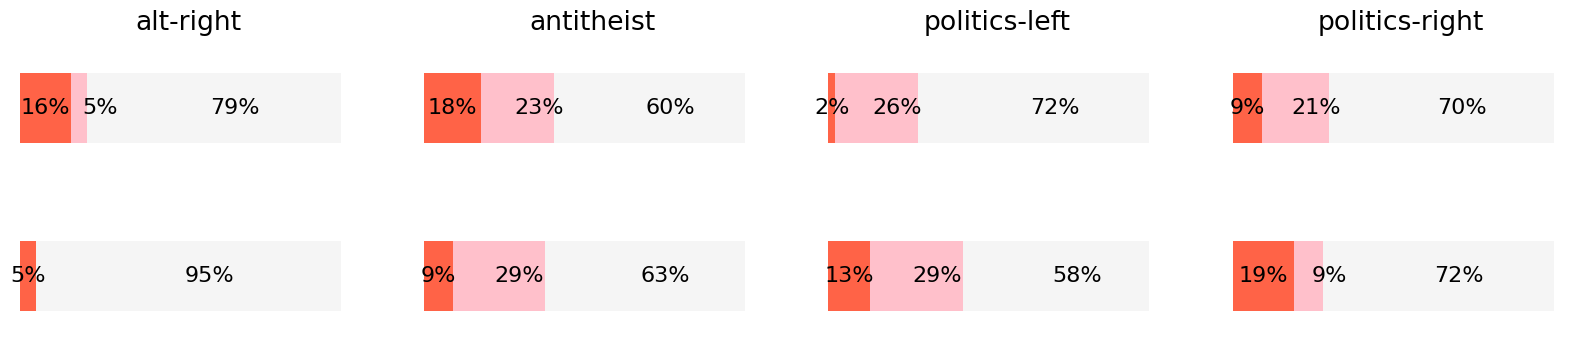

In [304]:
# Sources: 
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.barh.html#matplotlib.axes.Axes.barh
fig, axs = plt.subplots(2, 4, figsize=(20, 4))
for comp_idx in range(len(axs)):
    component = components[comp_idx]
    for topic_idx in range(len(axs[comp_idx])):
        topic = topics[topic_idx]
        
        ax = axs[comp_idx][topic_idx]

        ratios = num_p2_watched_final.loc[(component,('ratio',topic,slice(None)))]['ratio',topic]
        # This is a hack; we got lucky that the alphabetical order followed our desired order
        ratios = ratios.sort_index(ascending=False)
        #print(ratios)

        # For colors
        i = 0
        prev_width = 10
        for j, (width, label) in enumerate([*zip(ratios, ratios.index)]):
            bc = ax.barh(0, width, height, left=left, color=colors[i], label=label)
            if width > 0:
                # Adjust padding so that if the previous number is small then this label doesn't overlap with it
                ax.bar_label(bc, labels=['{0}%'.format(round(width*100))], label_type='center', padding=15 if prev_width<10 else 0)
                prev_width = width
            i += 1    
            
            left += width

        if comp_idx==0:
            ax.set_title('{0}'.format(topic))
        ax.axis('off')
        ax.set_ylim(- 1 * height, 1 * height)

        # Won't work!
        if topic_idx==0:
            #print('yes')
            ax.set_ylabel('{0}'.format(component))

        #if comp_idx==0 and topic_idx==len(axs[comp_idx])-1:
            #ax.legend(loc = 'right')

plt.show()

## P3 analysis for explicit scrubbed vs. not, topical recommendations

In [305]:
scrubbed=all_levels_df[
    (all_levels_df['homepage_level']>39)&
    (all_levels_df['homepage_level']<79)&
    (all_levels_df['strategy'].isin(['dislike-recommendation','not-interested','no-channel']))&
    (all_levels_df['on_list'])
].groupby(['bot_name','homepage_level'])['channel_id'].agg('first')
scrubbed

bot_name                            homepage_level
alt-right_dislike-recommendation_0  40                UCkY8CvV8WQFe87CZGmvuYHA
                                    41                UCHC60upCUfq7EAfw6oDQRDA
                                    42                UCN0-RRaxMgh86eOwndAklxw
                                    44                UCLM6JlQkQ9tltBL9Bipci9g
                                    48                UCmrLCXSDScliR7q8AxxjvXg
                                                                ...           
random_not-interested_3             40                UC9Ed9JvjK_UDDpj8C_tMaqg
                                    41                UCY1gTTyBQ8m9ZoRpd7rgQCg
                                    42                UC5tkSsOxlr91yi30Rs5qtfg
                                    43                UCBjBZmguQzn6WCYR7DQykLw
                                    46                UC_LDtFt-RADAdI8zIW_ecbg
Name: channel_id, Length: 1042, dtype: object

In [306]:
scrubbed_chans = scrubbed.groupby('bot_name').agg(lambda x: set(x.unique()))
scrubbed_chans

bot_name
alt-right_dislike-recommendation_0    {UCmrLCXSDScliR7q8AxxjvXg, UCLM6JlQkQ9tltBL9Bi...
alt-right_dislike-recommendation_1    {UCmrLCXSDScliR7q8AxxjvXg, UCLM6JlQkQ9tltBL9Bi...
alt-right_dislike-recommendation_2    {UCLM6JlQkQ9tltBL9Bipci9g, UCZtDKD0pFpPclXA7ZA...
alt-right_dislike-recommendation_3    {UCHC60upCUfq7EAfw6oDQRDA, UCBceihEYR7elOoeWTu...
alt-right_dislike-recommendation_4    {UCmrLCXSDScliR7q8AxxjvXg, UCur6nu-T7FilkEztCm...
                                                            ...                        
random_no-channel_4                   {UCZu9AV3mrCCDpK_dy1qJRAQ, UCVtQlNwE9mrNeJ8aIL...
random_not-interested_0               {UC9Ed9JvjK_UDDpj8C_tMaqg, UC6iyyIykxed9HQpBhs...
random_not-interested_1               {UC9Ed9JvjK_UDDpj8C_tMaqg, UCSjlTrPYRxwiNzjGiu...
random_not-interested_2               {UCCl-77F5QnREAcBcMT9o7aQ, UCs0nji0Wy6WRV630Dz...
random_not-interested_3               {UC9Ed9JvjK_UDDpj8C_tMaqg, UC_LDtFt-RADAdI8zIW...
Name: channel_id, Lengt

In [307]:
scrubbed_chans = pd.concat([scrubbed_chans, watched[list(set(watched.index) - set(scrubbed_chans.index))]])


In [308]:
scrubbed_chans

bot_name
alt-right_dislike-recommendation_0    {UCmrLCXSDScliR7q8AxxjvXg, UCLM6JlQkQ9tltBL9Bi...
alt-right_dislike-recommendation_1    {UCmrLCXSDScliR7q8AxxjvXg, UCLM6JlQkQ9tltBL9Bi...
alt-right_dislike-recommendation_2    {UCLM6JlQkQ9tltBL9Bipci9g, UCZtDKD0pFpPclXA7ZA...
alt-right_dislike-recommendation_3    {UCHC60upCUfq7EAfw6oDQRDA, UCBceihEYR7elOoeWTu...
alt-right_dislike-recommendation_4    {UCmrLCXSDScliR7q8AxxjvXg, UCur6nu-T7FilkEztCm...
                                                            ...                        
antitheist_dislike_1                  {UCRjbj9qTybLvdnSx6SX5Onw, UC28jWiP7HV6mBBW3C8...
random_dislike_0                      {UCnUib9_1oRyUQJJUYSTGXgg, UCHPDgXw1lRrr34nkGt...
alt-right_dislike_4                   {UCur6nu-T7FilkEztCm_S8yA, UCLM6JlQkQ9tltBL9Bi...
alt-right_delete_2                    {UCur6nu-T7FilkEztCm_S8yA, UCLM6JlQkQ9tltBL9Bi...
random_watch_1                        {UCnUib9_1oRyUQJJUYSTGXgg, UC99Lizquk6exc9r8cu...
Length: 173, dtype: obj

In [309]:
def get_channel_type_p3(x):
    # 2024 discovered bug: Change from "watched" to scrubbed_chans (same result)
    if x.channel_id in scrubbed_chans[x.bot_name]:
        return 'on-topic scrubbed'
    if x.on_topic:
        return 'on-topic new'
    return 'off-topic'

In [310]:
p3_hp_df = df[
    (df['exp_stage']==3)&
    (df['component']=='homepage')&
    (df['strategy']!='none')
]
p3_vp_df = df[
    (df['exp_stage']==3)&
    (df['component']=='videopage')&
    (df['strategy']!='none')
]

p3_hp_df['channel_type'] = p3_hp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p3,axis=1)
p3_vp_df['channel_type'] = p3_vp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p3,axis=1)


/var/folders/t6/srtzy2f51db8mxxv7g_63f6h0000gr/T/ipykernel_61868/867851526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p3_hp_df['channel_type'] = p3_hp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p3,axis=1)
/var/folders/t6/srtzy2f51db8mxxv7g_63f6h0000gr/T/ipykernel_61868/867851526.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p3_vp_df['channel_type'] = p3_vp_df[['bot_name','channel_id','on_topic']].apply(get_channel_type_p3,axis=1)


In [311]:
def scrubbed_str(s):
    ot = 0
    ots = 0
    otns = 0
    
    if 'on-topic not-scrubbed' in s.keys():
        otns = s['on-topic not-scrubbed']
    if 'on-topic scrubbed' in s.keys():
        ots = s['on-topic scrubbed']
    if 'off-topic' in s.keys():
        ot = s['off-topic']
        
    ret_str = ''
    for i in range(round(ot*20)):
        ret_str += 'x'
    for i in range(round(ots*20)):
        ret_str += 'o'
    for i in range(round(otns*20)):
        ret_str += '+'
    
    return ret_str

In [312]:
def scrubbed_str_2(s):
    ot = 0
    ots = 0
    otns = 0
    
    if 'on-topic not-scrubbed' in s.keys():
        otns = s['on-topic not-scrubbed']
    if 'on-topic scrubbed' in s.keys():
        ots = s['on-topic scrubbed']
    if 'off-topic' in s.keys():
        ot = s['off-topic']
    
    return '{0:.0f}%,{1:.0f}%,{2:.0f}% ({3})'.format(round(ot*100),round(ots*100),round(otns*100),s['total'])

In [313]:
p3_hp_final = p3_hp_df.groupby(['topic','strategy'])['channel_type'].apply(
    lambda x: dict(x.value_counts(normalize=True)),
).fillna(0).apply(
    lambda x: '{0:.0f}%'.format(round(x*100))
).unstack([0,2]).loc[strategies[1:]]

p3_hp_final

topic                  alt-right                                antitheist  \
                       off-topic on-topic new on-topic scrubbed  off-topic   
strategy                                                                     
watch                        90%           2%                8%        74%   
delete                       96%           4%                0%        74%   
dislike                      92%           6%                2%        84%   
not-interested              100%           0%                0%        96%   
no-channel                   84%          16%                0%        78%   
dislike-recommendation       90%           8%                2%        80%   

topic                                                 politics-left  \
                       on-topic new on-topic scrubbed     off-topic   
strategy                                                              
watch                           12%               14%           78%   
delete                           8%               18%          100%   
dislike                          6%               10%           72%   
not-interested                   4%                0%           90%   
no-channel                      22%                0%           84%   
dislike-recommendation          20%                0%           76%   

topic                                                 politics-right  \
                       on-topic new on-topic scrubbed      off-topic   
strategy                                                               
watch                           20%                2%            82%   
delete                           0%                0%            94%   
dislike                         28%                0%            84%   
not-interested                  10%                0%            94%   
no-channel                      16%                0%            76%   
dislike-recommendation          24%                0%            64%   

topic                                                  
                       on-topic new on-topic scrubbed  
strategy                                               
watch                           12%                6%  
delete                           4%                2%  
dislike                         14%                2%  
not-interested                   6%                0%  
no-channel                      24%                0%  
dislike-recommendation          32%                4%

In [314]:
p3_hp_final.to_csv('./tables/p3_hp_final.csv')

Not including videopage due to no significant effects

In [315]:
num_p3_scrubbed_final = p3_hp_final.applymap(lambda x: int(x[:-1])/100)
num_p3_scrubbed_final

topic                  alt-right                                antitheist  \
                       off-topic on-topic new on-topic scrubbed  off-topic   
strategy                                                                     
watch                       0.90         0.02              0.08       0.74   
delete                      0.96         0.04              0.00       0.74   
dislike                     0.92         0.06              0.02       0.84   
not-interested              1.00         0.00              0.00       0.96   
no-channel                  0.84         0.16              0.00       0.78   
dislike-recommendation      0.90         0.08              0.02       0.80   

topic                                                 politics-left  \
                       on-topic new on-topic scrubbed     off-topic   
strategy                                                              
watch                          0.12              0.14          0.78   
delete                         0.08              0.18          1.00   
dislike                        0.06              0.10          0.72   
not-interested                 0.04              0.00          0.90   
no-channel                     0.22              0.00          0.84   
dislike-recommendation         0.20              0.00          0.76   

topic                                                 politics-right  \
                       on-topic new on-topic scrubbed      off-topic   
strategy                                                               
watch                          0.20              0.02           0.82   
delete                         0.00              0.00           0.94   
dislike                        0.28              0.00           0.84   
not-interested                 0.10              0.00           0.94   
no-channel                     0.16              0.00           0.76   
dislike-recommendation         0.24              0.00           0.64   

topic                                                  
                       on-topic new on-topic scrubbed  
strategy                                               
watch                          0.12              0.06  
delete                         0.04              0.02  
dislike                        0.14              0.02  
not-interested                 0.06              0.00  
no-channel                     0.24              0.00  
dislike-recommendation         0.32              0.04

In [316]:
num_p3_scrubbed_final[[
            (     'alt-right',         'off-topic'),
            (     'alt-right', 'on-topic scrubbed'),
            (     'alt-right',      'on-topic new'),
            (    'antitheist',         'off-topic'),
            (    'antitheist', 'on-topic scrubbed'),
            (    'antitheist',      'on-topic new'),
            ( 'politics-left',         'off-topic'),
            ( 'politics-left', 'on-topic scrubbed'),
            ( 'politics-left',      'on-topic new'),
            ('politics-right',         'off-topic'),
            ('politics-right', 'on-topic scrubbed'),
            ('politics-right',      'on-topic new')
]]

topic                  alt-right                                antitheist  \
                       off-topic on-topic scrubbed on-topic new  off-topic   
strategy                                                                     
watch                       0.90              0.08         0.02       0.74   
delete                      0.96              0.00         0.04       0.74   
dislike                     0.92              0.02         0.06       0.84   
not-interested              1.00              0.00         0.00       0.96   
no-channel                  0.84              0.00         0.16       0.78   
dislike-recommendation      0.90              0.02         0.08       0.80   

topic                                                 politics-left  \
                       on-topic scrubbed on-topic new     off-topic   
strategy                                                              
watch                               0.14         0.12          0.78   
delete                              0.18         0.08          1.00   
dislike                             0.10         0.06          0.72   
not-interested                      0.00         0.04          0.90   
no-channel                          0.00         0.22          0.84   
dislike-recommendation              0.00         0.20          0.76   

topic                                                 politics-right  \
                       on-topic scrubbed on-topic new      off-topic   
strategy                                                               
watch                               0.02         0.20           0.82   
delete                              0.00         0.00           0.94   
dislike                             0.00         0.28           0.84   
not-interested                      0.00         0.10           0.94   
no-channel                          0.00         0.16           0.76   
dislike-recommendation              0.00         0.24           0.64   

topic                                                  
                       on-topic scrubbed on-topic new  
strategy                                               
watch                               0.06         0.12  
delete                              0.02         0.04  
dislike                             0.02         0.14  
not-interested                      0.00         0.06  
no-channel                          0.00         0.24  
dislike-recommendation              0.04         0.32

In [317]:
left = 0
height = .5
colors = ['tomato','pink','whitesmoke']
components = ['homepage', 'videopage']
plt.rcParams.update({'font.size': 18})

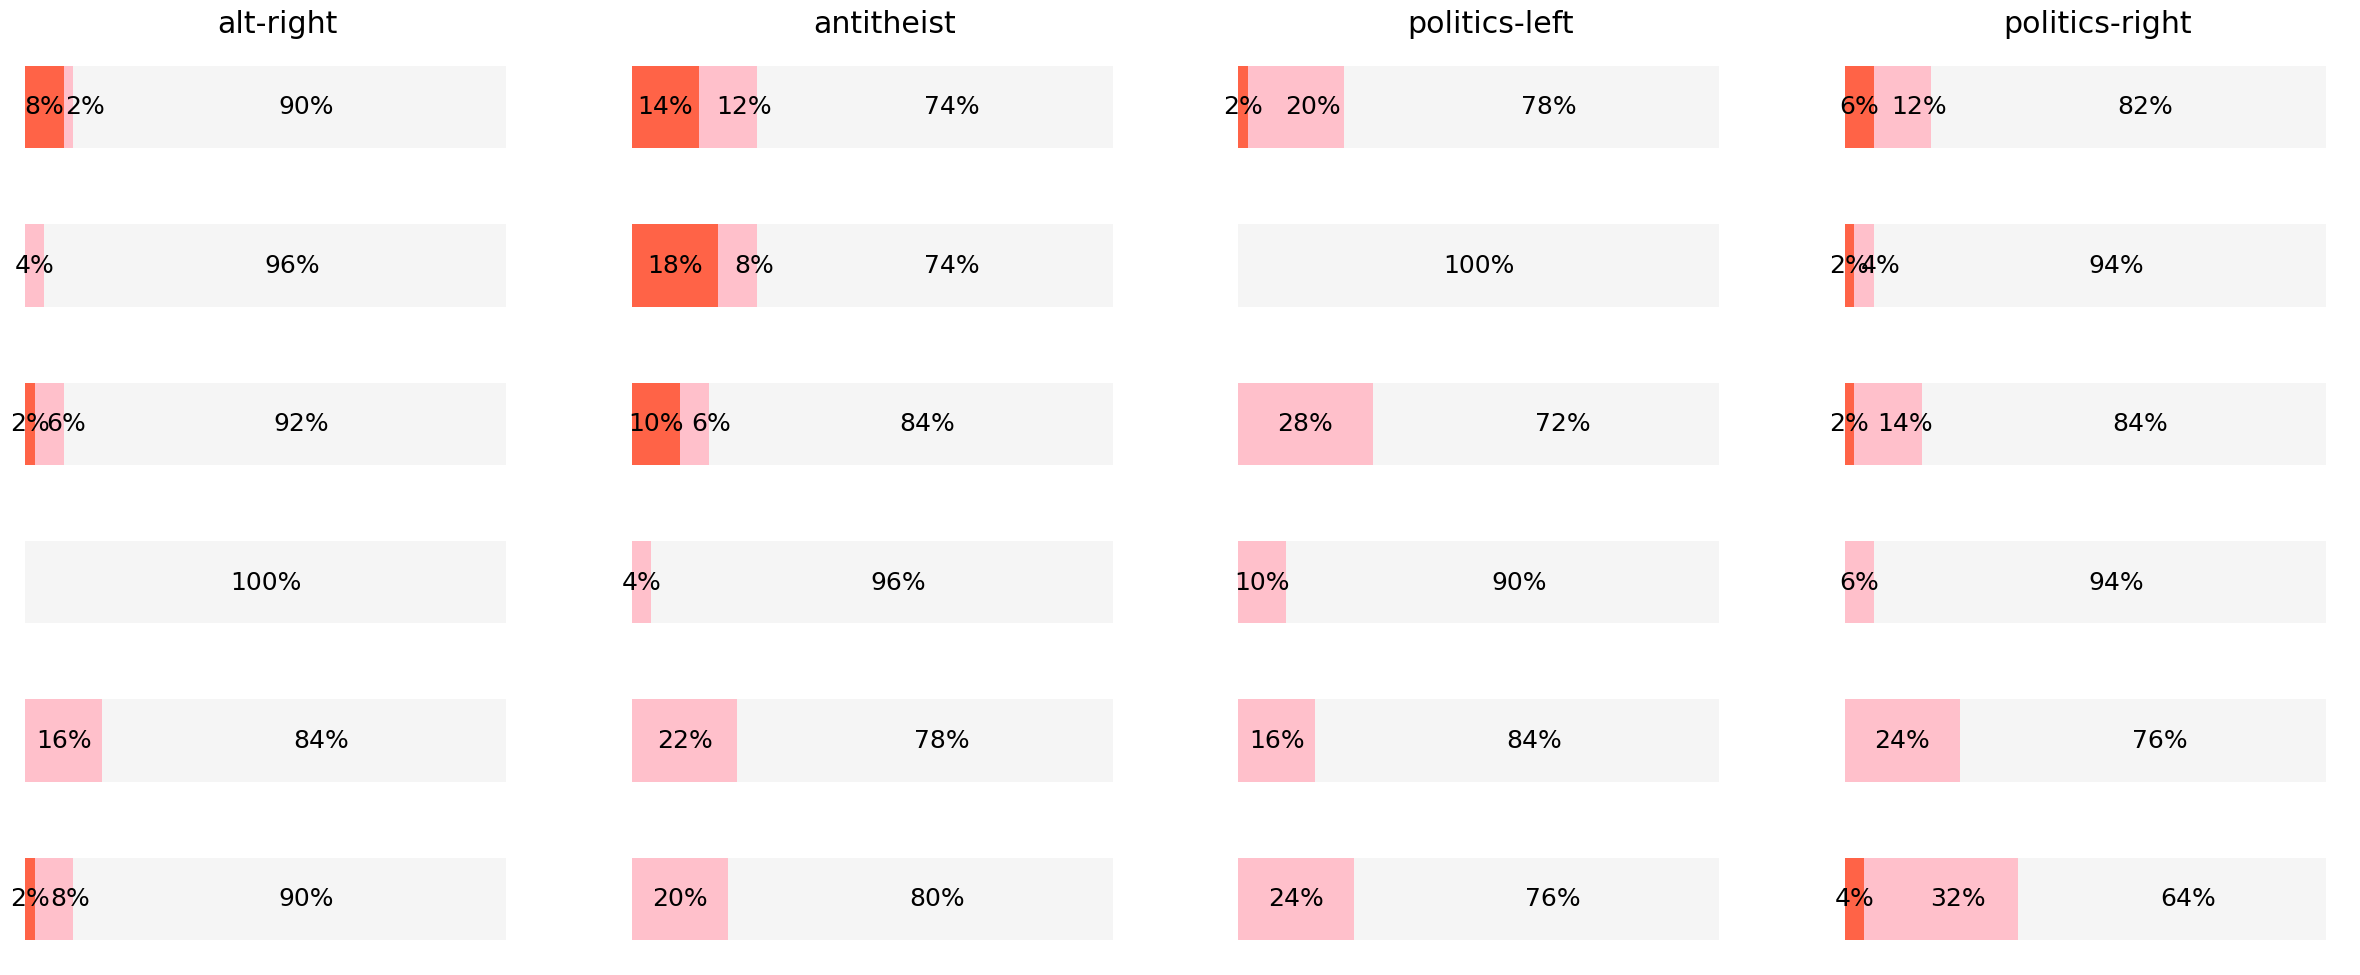

In [318]:
# Source: https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html
fig, axs = plt.subplots(6, 4, figsize=(30, 12))

for strategy_idx in range(len(axs)):
    # don't use none strategy
    strategy = strategies[1:][strategy_idx]
        
    for topic_idx in range(len(axs[strategy_idx])):
        topic = topics[topic_idx]
        
        ax = axs[strategy_idx][topic_idx]

        ratios = num_p3_scrubbed_final.loc[(strategy,(topic,slice(None)))][topic]
        # This is a hack; we got lucky that the alphabetical order followed our desired order
        ratios = ratios.sort_index(ascending=False)

        # For colors
        i = 0
        prev_width=10
        for j, (width, label) in enumerate([*zip(ratios, ratios.index)]):
            bc = ax.barh(0, width, height, left=left, color=colors[i], label=label)
            if width > 0:
                ax.bar_label(bc, labels=[f"{width:.0%}"], label_type='center', padding=12 if prev_width<10 else 0)
                prev_width=width
            i += 1
            left += width
            

        if strategy_idx==0:
            ax.set_title('{0}'.format(topic))
        ax.axis('off')
        ax.set_ylim(- 0.8 * height, 0.8 * height)

        # Won't work!
        if topic_idx==0:
            #print('yes')
            ax.set_ylabel('{0}'.format(strategy))

plt.show()

In [319]:
strategies[1:]

['watch',
 'delete',
 'dislike',
 'not-interested',
 'no-channel',
 'dislike-recommendation']

## wilc tests

In [320]:
df_homepage = df[
    (df['component']=='homepage')&
    (df['exp_stage'].isin([1,2,3]))
]

df_videopage = df[
    (df['component']=='videopage')&
    (df['exp_stage'].isin([1,2,3]))
]

In [321]:
df_videopage['exp_stage'].unique()

array([1, 2, 3])

In [322]:
stain_hp = df_homepage.groupby(['topic','strategy','exp_stage','note'])['on_topic'].agg(
    lambda x: x.sum() / len(x)
).unstack('exp_stage')
stain_vp = df_videopage.groupby(['topic','strategy','exp_stage','note'])['on_topic'].agg(
    lambda x: x.sum() / len(x)
).unstack('exp_stage')

[TODO] Normality test (takeaway: Non-normal on more than half of P1/P2; P3 not enough samples (need at least 8 and we have 5 per topic/strategy combo)

In [323]:
# either do p1-p2, or p2-p3
def get_significant_wilc(x, do_12):    
    p1 = x[1]
    p2 = x[2]
    p3 = x[3]
    
    #print(p1)
    #print(p2)
    #print( ((p1-p2)!=0).sum()==0 )
    
    # not significant if no change
    stat_12, pval_12, stat_23, pval_23 = 1,1,1,1
    if ((p1-p2)!=0).sum()>0:
        stat_12, pval_12 = wilcoxon(list(p1),list(p2), alternative='less')
    if ((p2-p3)!=0).sum()>0:
        stat_23, pval_23 = wilcoxon(list(p2),list(p3), alternative='greater')

    threshold = 0.05
    
    if do_12:

        return pd.Series({
            'p1': '{0:.0f}%'.format(round(np.mean(p1)*100)),
            '12sig': '***' if pval_12 < threshold else '   ',
            'p2': '{0:.0f}%'.format(round(np.mean(p2)*100)),
            '23_sig': '',
            'p3': ''
        })
    
    else:
        return pd.Series({
            'p1': '',
            '12sig': '',
            'p2': '{0:.0f}%'.format(round(np.mean(p2)*100)),
            '23_sig': '***' if pval_23 < threshold else '   ',
            'p3': '{0:.0f}%'.format(round(np.mean(p3)*100))
        })

In [324]:
def get_average_diff(x):
    #print(x)
    all_diffs = []
    for t in topics:
        num = np.mean(x.loc[(t,slice(None),),3])
        den = np.mean(x.loc[(t,slice(None),),2])
        if den == 0:
            all_diffs.append(0)
        else:
            all_diffs.append( (num / den) - 1 )
    return '{0:.0f}%'.format(round(np.mean(all_diffs)*100))

In [325]:
pd.options.display.max_columns = 100


In [ ]:
# p1, p2, and significant change
hp_p1_p2 = stain_hp.groupby(['topic']).apply(
    lambda x: get_significant_wilc(x, do_12=True)
)
hp_p1_p2 = hp_p1_p2.stack()
hp_p1_p2.index.rename(['topic','metric'],inplace=True)
hp_p1_p2.rename('total',inplace=True)
#hp_p1_p2

# p2, p3, and significant change
hp_p2_p3 = stain_hp.groupby(['strategy','topic']).apply(
    lambda x: get_significant_wilc(x, do_12=False)
).stack()
hp_p2_p3.index.rename(['strategy','topic','metric'],inplace=True)
hp_p2_p3 = hp_p2_p3.unstack(['topic','metric'])
#hp_p2_p3

# average difference
hp_p2_p3_diff = stain_hp.groupby(['strategy']).apply(
    get_average_diff
)
hp_p2_p3_diff = hp_p2_p3_diff.rename(('average','23change'))
#hp_p2_p3_diff

In [327]:
# Join up, then join right, then sort
wilc_hp_final = hp_p2_p3.T.join(hp_p1_p2).T
wilc_hp_final = wilc_hp_final.join(hp_p2_p3_diff)

# Join right, then join up, then sort
#wilc_hp_final = hp_p2_p3.join(hp_p2_p3_diff)
#wilc_hp_final = wilc_hp_final.T.join(hp_p1_p2).T

wilc_hp_final = wilc_hp_final.loc[['total']+strategies].fillna('')

In [328]:
wilc_hp_final

alt-right                        antitheist             \
                              p1 12sig   p2 23_sig   p3         p1 12sig   p2   
total                         2%   ***  20%                    11%   ***  37%   
none                                    20%         22%                   32%   
watch                                   12%          8%                   34%   
delete                                  20%    ***   0%                   32%   
dislike                                 20%          4%                   30%   
not-interested                          18%    ***   0%                   42%   
no-channel                              28%    ***  10%                   44%   
dislike-recommendation                  20%    ***   8%                   42%   

                                   politics-left                         \
                       23_sig   p3            p1 12sig   p2 23_sig   p3   
total                                         6%   ***  28%               
none                           38%                      20%         34%   
watch                          22%                      32%    ***  18%   
delete                         24%                      30%    ***   0%   
dislike                   ***  10%                      24%         28%   
not-interested            ***   2%                      28%    ***  10%   
no-channel                ***  22%                      30%    ***  16%   
dislike-recommendation    ***  14%                      32%         24%   

                       politics-right                         average  
                                   p1 12sig   p2 23_sig   p3 23change  
total                              9%   ***  29%                       
none                                         32%         42%      32%  
watch                                        26%    ***  16%     -38%  
delete                                       24%    ***   4%     -77%  
dislike                                      32%    ***  16%     -45%  
not-interested                               26%    ***   2%     -88%  
no-channel                                   36%    ***  24%     -49%  
dislike-recommendation                       26%         34%     -30%

In [329]:
wilc_hp_final.to_csv('./tables/wilc_hp_final.csv')

In [ ]:
# p1, p2, and significant change
vp_p1_p2 = stain_vp.groupby(['topic']).apply(
    lambda x: get_significant_wilc(x, do_12=True)
)
vp_p1_p2 = vp_p1_p2.stack()
vp_p1_p2.index.rename(['topic','metric'],inplace=True)
vp_p1_p2.rename('total',inplace=True)
#vp_p1_p2

# p2, p3, and significant change
vp_p2_p3 = stain_vp.groupby(['strategy','topic']).apply(
    lambda x: get_significant_wilc(x, do_12=False)
).stack()
vp_p2_p3.index.rename(['strategy','topic','metric'],inplace=True)
vp_p2_p3 = vp_p2_p3.unstack(['topic','metric'])
#vp_p2_p3

# average difference
vp_p2_p3_diff = stain_vp.groupby(['strategy']).apply(
    get_average_diff
)
vp_p2_p3_diff = vp_p2_p3_diff.rename(('average','23change'))
#vp_p2_p3_diff

# Join up, then join right, then sort
wilc_vp_final = vp_p2_p3.T.join(vp_p1_p2).T
wilc_vp_final = wilc_vp_final.join(vp_p2_p3_diff)

# Join right, then join up, then sort
#wilc_vp_final = vp_p2_p3.join(vp_p2_p3_diff)
#wilc_vp_final = wilc_vp_final.T.join(vp_p1_p2).T
wilc_vp_final = wilc_vp_final.loc[['total']+strategies].fillna('')

In [331]:
wilc_vp_final

alt-right                        antitheist             \
                              p1 12sig   p2 23_sig   p3         p1 12sig   p2   
total                         6%         5%                    26%   ***  37%   
none                                     6%          4%                   40%   
watch                                    4%          6%                   28%   
delete                                   2%          2%                   38%   
dislike                                 12%         14%                   40%   
not-interested                           4%          2%                   40%   
no-channel                               0%          0%                   32%   
dislike-recommendation                   6%          2%                   42%   

                                   politics-left                         \
                       23_sig   p3            p1 12sig   p2 23_sig   p3   
total                                        41%        42%               
none                           34%                      38%         34%   
watch                           6%                      42%         46%   
delete                         34%                      42%         34%   
dislike                        34%                      44%         46%   
not-interested                 48%                      44%         44%   
no-channel                     30%                      44%         40%   
dislike-recommendation         34%                      40%         50%   

                       politics-right                         average  
                                   p1 12sig   p2 23_sig   p3 23change  
total                             12%   ***  28%                       
none                                         20%         30%      -2%  
watch                                        30%         34%      -1%  
delete                                       32%         16%     -20%  
dislike                                      22%         42%      24%  
not-interested                               32%         30%      -9%  
no-channel                                   34%         36%      -2%  
dislike-recommendation                       24%         22%     -17%

In [332]:
wilc_vp_final.to_csv('./tables/wilc_vp_final.csv')

In [333]:
#5/13 wilcoxon ranked sum test for significance between p1 and p2, p2 and p3
threshold = 0.05
stain_hp.groupby('strategy').apply(lambda x: wilcoxon(list(x[1]),list(x[2]), alternative='less')).apply(lambda y: y.pvalue < threshold)
stain_hp.groupby('strategy').apply(lambda x: wilcoxon(list(x[2]),list(x[3]), alternative='greater')).apply(lambda y: y.pvalue < threshold)

/Users/avliu/miniforge3/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/avliu/miniforge3/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


strategy
delete                     True
dislike                    True
dislike-recommendation     True
no-channel                 True
none                      False
not-interested             True
watch                      True
dtype: bool